# [Part 3] - Achieving Privacy with Private Aggregation of Teacher Ensembles (PATE)

# Introduction

This notebook belongs to a 4-parts project. This part is dedicated to implement a training strategy that ensures privacy, called PATE, which was introduced by Papernot et al (2017) on their paper [Semi-supervised knowledge transfer for Deep Learning from private training data](https://arxiv.org/abs/1610.05755). 

Additionally, we use an utility function from [PySyft](https://github.com/OpenMined/PySyft), a library for encrypted, privacy preserving deep learning, that allow us to analyze our PATE implementation and know how private our learning strategy is. For this reason we start by installing PySyft, which also will be useful for the 4th part of this project.

In [ ]:
%%capture
!pip install syft

In [1]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Our helper (takes a while because we load all data there as well)
import helper

from syft.frameworks.torch.differential_privacy import pate

W0820 12:51:08.221711 4337219008 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/anaconda3/envs/pysyft/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0820 12:51:08.231410 4337219008 deprecation_wrapper.py:119] From /anaconda3/envs/pysyft/lib/python3.7/site-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
exp_i_data = helper.load_exp_i("dataset/experiment-i")
exp_ii_data_air, exp_ii_data_spo = helper.load_exp_ii("dataset/experiment-ii")

datasets = {
    "Base":exp_i_data,
    "Spo":exp_ii_data_air,
    "Air":exp_ii_data_spo
}

# PATE Overview 

Privacy methods in deep learning (and machine learning in general) arise as a necessity of ensuring the subjects, whose data is being used for modeling, that the models are not storing any sensitive data and that there is no way of retreiving it by neither using the model nor by examining its parameters.

Sensitive data can be thought, for example, in a medical scenario, where models can be created for example to improve the diagnostics capabilities of hospitals, but at thhe same time patients do not want to leak any of their personal (or medical) information by contributing with their data to the creation of a machine learning model.

The difficulty arises when the goals is to guarantee to *every person* that their private data is, in fact, private. Most training methods cannot accomplish this, because even though the models look forward to generalize to the test set, they can still overfit on outliers (specific training examples). 

PATE (stands for Private Aggregation of Teacher Ensembles) is a model-agnostic learning strategy, meaning that it can be implemented no matter what learning algorithm is being used for a specific task. It works by creating a teachers-student scenario, where the teachers represent already available models for a task and the student is the new model to develop for the same task. The student's training phase uses labels that are acquired from the aggregated votes that teachers generate for every data point, and privacy is ensured by adding some noise to the teacher votes.

After training, the student model is the one deployed, instead of the teacher ensemble.

# Our proposed scenario

We simulate the following scenario with the data we have been working on to develop the idea of PATE: 

* We work on a hospital where we have three patitents who have used a pressure mattress. We would like to monitor their in-bed lying positions to, among others, prevent any skin lesion if they stay on the same position for a long time period. We have, however, no model to accomplish this but we know that there are ten hospitals who built a model using their own data. We ask them to borrow us their models, which we will use to train ours. Additionally, we want to ensure that the data contained in their models will not be leaked, even though that their models per-se might leak private data or contain sensitive information. Additionally, we want to ensure *our patients* that our model will not overfit and contain any of their private information (i.e., by looking at the model parameters or by using it, nobody would be able to generate an image of their exact pressure recordings).

* We regard every subject collection of measurements (from S1 to S10) as data collected from *individual hospitals*, meaning that there are ten hospitals available to help. Their models are the **teacher models**.

* We possess data of S11 to S13, and we want to create a model on our data, based on the teacher votes. Our model is the **student model**.

* We assume for simplicity that the architecture of all models is the same. We use the proposed architecture in part 2, a convolutional neural network, which can be instanciated via `helper.py` by callling `CNN()`.

## STEP 1: Gather the Teachers

Let's begin by creating a function to train the teachers. While on a real application we should get already trained models from the hospitals, our simulated scenario require us to train the models. For this, we instantiate a CNN and set the learning strategy on `train_teacher()`

In [3]:
def train_teacher(device, trainloader, epochs=15, seed=123):
  model = helper.CNN()

  criterion = nn.NLLLoss()

  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  model.to(device)

  torch.manual_seed(seed)

  for epoch in range(epochs):
    for inputs, labels in trainloader:

      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()

  return model

## STEP 2: Gather the teacher votes

The idea of PATE is that every teacher examines the data we want to train our model on (that is, data from S11, S12, and S13)  and generates a prediction for each image. This prediction is the teacher's _vote_ and we gather all of the votes together for every image.

We achieve this on this chunk by doing the following:

+ We loop for every hospital, getting the data of this hospital (`private_data`) and then training a model on it.
  + This trained model (teacher) generates predictions on our data `my_data`.
  + We also calculate the accuracy of every single teacher in our data. We do this for the purpose of the PATE analysis, because on a real setting we would not have any labels for our data.
+ We gather all teacher votes into a matrix, the dimensions of it should be `(number_of_images x number_of_teachers)`


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hospitals = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

hospitals_preds = {}

my_hospital = ["S11", "S12", "S13"]

my_data = helper.Mat_Dataset(["Base"], my_hospital)
my_data_loader = DataLoader(my_data, batch_size=len(my_data), shuffle=False)

for hospital in hospitals:
  
  print(f'Training teacher on {hospital} data')
  
  private_data = helper.Mat_Dataset(["Base"], [hospital])
  private_data_loader = DataLoader(private_data, batch_size=64, shuffle=True)
  private_model = train_teacher(device, private_data_loader)
  
  accuracy = 0
  private_model.to(device)
  private_model.eval()
  with torch.no_grad():
      
    for inputs, labels in my_data_loader:

      inputs, labels = inputs.to(device), labels.to(device)
      logps = private_model.forward(inputs)
      ps = torch.exp(logps)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.type(torch.FloatTensor))
      print(f"- Accuracy on our data: {accuracy/len(my_data_loader):.3f}")
      hospitals_preds[hospital] = top_class
    
  

Training teacher on S1 data
- Accuracy on our data: 0.742
Training teacher on S2 data
- Accuracy on our data: 0.865
Training teacher on S3 data
- Accuracy on our data: 0.963
Training teacher on S4 data
- Accuracy on our data: 0.895
Training teacher on S5 data
- Accuracy on our data: 0.859
Training teacher on S6 data
- Accuracy on our data: 0.867
Training teacher on S7 data
- Accuracy on our data: 0.829
Training teacher on S8 data
- Accuracy on our data: 0.822
Training teacher on S9 data
- Accuracy on our data: 0.968
Training teacher on S10 data
- Accuracy on our data: 0.872


In [5]:
hospital_p = np.hstack([hospitals_preds.get(key).cpu() for key in hospitals_preds.keys()])
hospital_p.shape

(4324, 10)

## STEP 3: Add noise

To ensure privacy, we apply some noise to the votes before applying plurality (i.e., choosing the label with the largest count). Theoretical justifications can be found [in this paper](https://arxiv.org/pdf/1610.05755.pdf) and giving them here are out of the scope of this project.

One of the intuitive reasons of applying noise is to avoid that, in the case of a tie between two votes, only one teacher (or dataset) is responsible for making several decisive votes, leading to overfitting.

Of course, there is no free lunch: adding large quantities of noise results on a decrease in the overall accuracy of the model.

We apply Laplacian noise on every vote. The following image (taken from [Wikipedia](https://en.wikipedia.org/wiki/Laplace_distribution)) shows the Laplacian distribution, which is defined by a location parameter (μ) and a scale parameter (b).

![Laplace Distribution](img/laplace_distribution.png)

In this work, we set `b = 1 / epsilon`, where epsilon is a number we define arbitrarily. We will vary epsilon to vary the amount of noise we give to the teacher votes.

In [6]:
# Number of classes in our setting
num_positions = 3

def hospitals_vote(hospital_p, epsilon=0.1):
  new_labels = list()

  for a_measurement in hospital_p:

    label_counts = np.bincount(a_measurement, minlength=num_positions)

    beta = 1 / epsilon

    for i in range(len(label_counts)):
      label_counts[i] += np.random.laplace(0, beta, 1)

    new_label = np.argmax(label_counts)

    new_labels.append(new_label)
  
  return np.array(new_labels)

## STEP 4: Analyze the results

PySyft has a great function to analyze our results after applying PATE: `pate.perform_analysis()`. The output we get is based on the theory behind differential privacy, where we analyze our learning algorithms by calculating their respective (ε,δ) values. Slightly speaking, we can consider this ε as the amount of data leaked by our algorithm. Additionally,  `pate.perform_analysis()` calculates an ε that is independent of our teacher votes and one that depends on it. We are interested in the latter, because if we suppose, for example, that all our teachers agree on the same vote, then we can add with more confidence some noise and be sure that the majority vote will be the same as the one without adding any noise.

In [7]:
from syft.frameworks.torch.differential_privacy import pate

print("Epsilon = 0.1")
indices = hospitals_vote(hospital_p, epsilon=0.1)
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=hospital_p.transpose(), indices=indices, noise_eps=0.1, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

print("Epsilon = 0.01")
indices = hospitals_vote(hospital_p, epsilon=0.01)
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=hospital_p.transpose(), indices=indices, noise_eps=0.01, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Epsilon = 0.1
Data Independent Epsilon: 184.47292546497027
Data Dependent Epsilon: 184.4729254649701
Epsilon = 0.01
Data Independent Epsilon: 7.202231366242557
Data Dependent Epsilon: 7.202231366242335


As expected, the more noise we give, the less information gets leaked (shown as a low value of `data_ind_eps`). However, what happened to the accuracy of the aggregated votes? Well, since we have labels in our simulated case, we can calculate this:

In [8]:
true_labels = my_data[:][1]
print("Epsilon = 1 (Almost no noise at all)")
indices = hospitals_vote(hospital_p, epsilon=1)
votes_acc = sum(np.array(indices) == true_labels)/np.shape(np.array(indices) == true_labels)[0]
print(f"Accuracy of the aggregated votes without almost no noise: {votes_acc:.3f}")

print("Epsilon = 0.1")
indices = hospitals_vote(hospital_p, epsilon=0.1)
votes_acc = sum(np.array(indices) == true_labels)/np.shape(np.array(indices) == true_labels)[0]
print(f"Accuracy of the aggregated votes: {votes_acc:.3f}")

print("Epsilon = 0.01")
indices = hospitals_vote(hospital_p, epsilon=0.01)
votes_acc = sum(np.array(indices) == true_labels)/np.shape(np.array(indices) == true_labels)[0]
print(f"Accuracy of the aggregated votes: {votes_acc:.3f}")

Epsilon = 1 (Almost no noise at all)
Accuracy of the aggregated votes without almost no noise: 0.932
Epsilon = 0.1
Accuracy of the aggregated votes: 0.551
Epsilon = 0.01
Accuracy of the aggregated votes: 0.352


The accuracy dropped dramatically! We can explain this by examining some noise values that are generated with the Laplace distribution:

In [9]:
for i in range(10):
  print(np.random.laplace(0, 1/0.1, 1))

[11.37609765]
[-22.89845685]
[-25.00192447]
[-3.01532858]
[10.64106731]
[4.41105405]
[2.83267913]
[6.89490391]
[-13.68992175]
[2.20059478]


As we can see, these numbers are big compared with the number of votes we get in our matrix. Therefore, in order to preserve privacy, we also need to generate a large amount of teachers.

> To ensure that the noisy label is likely to be the correct one, the noise scale should be small compared to the gap between the two largest values of the votes (for example, if we have three classes, ten teachers are the votes are [1, 2, 8], then the additive gap is six). Since the gap itself increases with the number of teachers, having more teachers would lower the privacy cost. (Idea taken from [Papernot et. al (2017](https://arxiv.org/abs/1610.05755)). 

# Improving our PATE results: increase the amount of teachers

Now we will extend our setting by creating several teachers for every hospital (i.e., several models for every subject data). We will test by creating 10, 15 and 20 models for every subject and we will plot the accuracy and ε with respect to the amount of noise we add. Additionally, we want to point out that every the subsets of data we use to model the individual teachers are all disjoint between each other.

Note that we can confidently increase the number of teachers in our dataset as the complexity of classifying the positions of this dataset is low for the `CNN()` we proposed. An in-depth analysis of how accuracy gets affected by splitting the training set into smaller parts is out of the scope of this project.

Running PATE using 100 teachers...
Running PATE using 150 teachers...
Running PATE using 300 teachers...


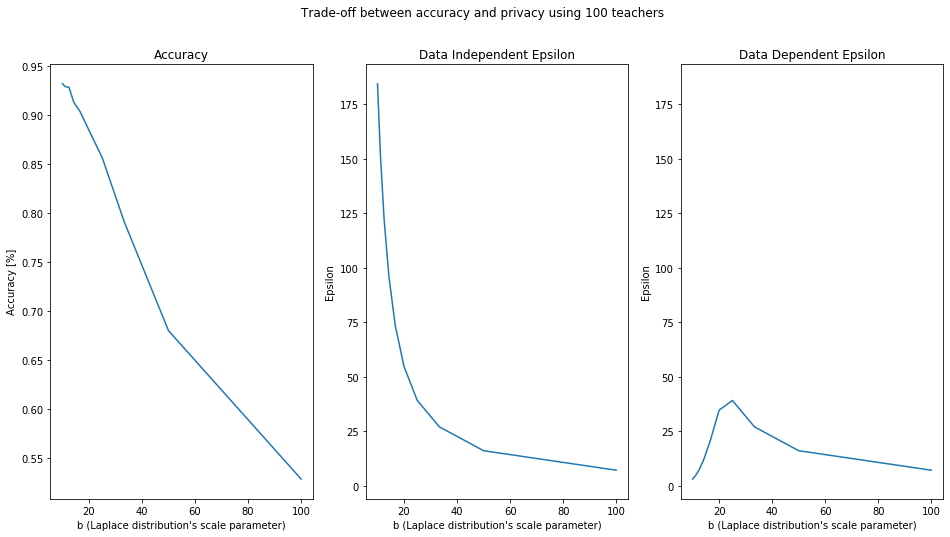

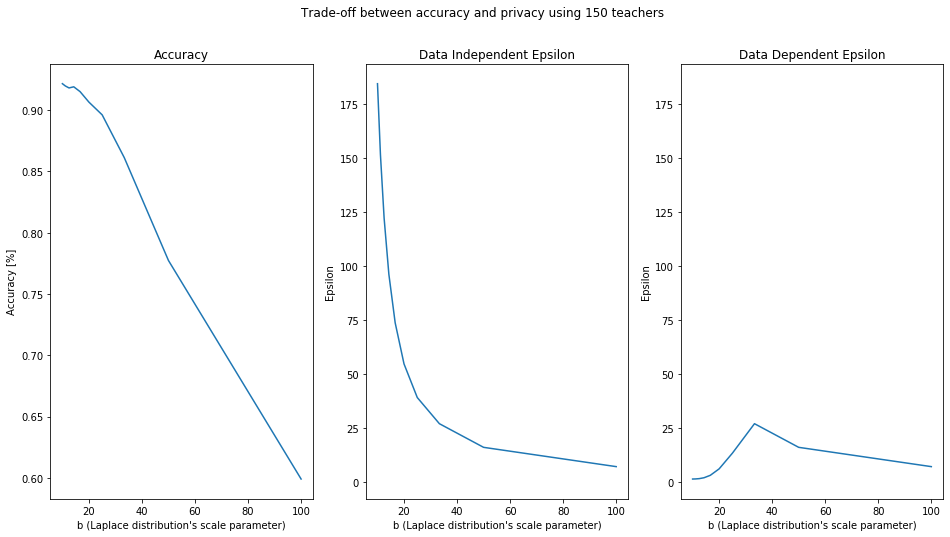

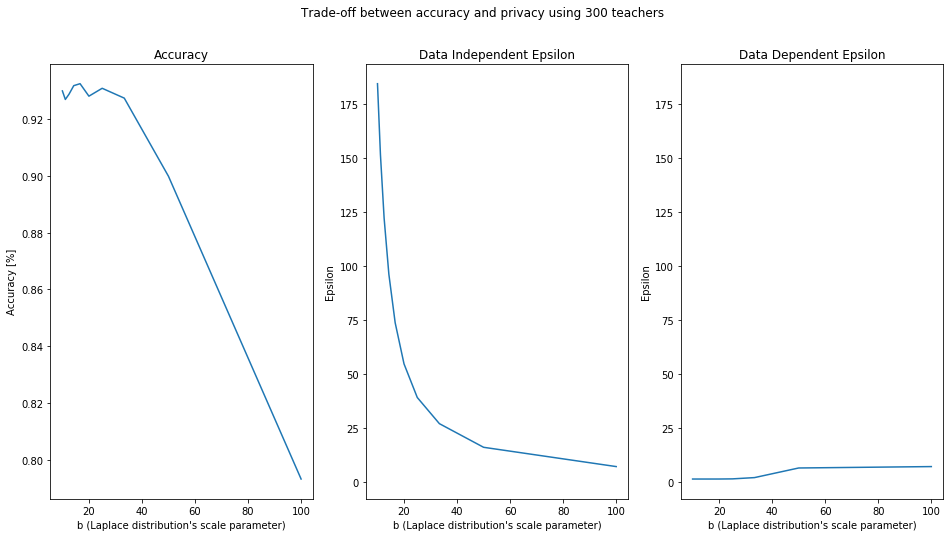

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hospitals = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

hospitals_preds = {}

my_hospital = ["S11", "S12", "S13"]

my_data = helper.Mat_Dataset(["Base"], my_hospital)
my_data_loader = DataLoader(my_data, batch_size=len(my_data), shuffle=False)

class Mini_Dataset(torch.utils.data.Dataset):
  def __init__(self, samples, labels):
    self.samples = samples
    self.labels = labels

  def __len__(self):
    return self.samples.shape[0]

  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

for n_teachers in [10, 15, 30]:
  
  print(f"Running PATE using {n_teachers * 10} teachers...")  
  for hospital in hospitals:
    private_data = helper.Mat_Dataset(["Base"], [hospital])
    n_images = len(private_data)
    batch_size = int(n_images/n_teachers)
    private_data_loader = DataLoader(private_data, batch_size=batch_size, shuffle=True)

    i = 0

    for samples, labels in iter(private_data_loader):
      mini_dataset = Mini_Dataset(samples, labels)
      if len(mini_dataset) < batch_size:
        continue
      mini_data_loader = DataLoader(mini_dataset, batch_size=int(len(mini_dataset)/5), shuffle=True)
      private_model = train_teacher(device, mini_data_loader)
      accuracy = 0
      private_model.to(device)
      private_model.eval()
      with torch.no_grad():

        for inputs, labels in my_data_loader:

          inputs, labels = inputs.to(device), labels.to(device)
          logps = private_model.forward(inputs)
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
          #print(f"Accuracy {accuracy/len(my_data_loader):.3f}, Hospital: {hospital}, Teacher: {i}")
          hospitals_preds[hospital + "_" +  str(i)] = top_class
          i += 1

  hospital_p = np.hstack([hospitals_preds.get(key).cpu() for key in hospitals_preds.keys()])
  num_positions = 3

  accuracies = []
  data_independent_eps = []
  data_dependent_eps = []
  noises = np.arange(0.1, 0, -0.01)
  for noise_eps in noises:
    indices = hospitals_vote(hospital_p, epsilon=noise_eps)
    data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=hospital_p.transpose(), indices=indices, noise_eps=noise_eps, delta=1e-5)
    #print("Data Independent Epsilon:", data_ind_eps)
    #print("Data Dependent Epsilon:", data_dep_eps)

    true_labels = my_data[:][1]
    accuracies.append(sum(np.array(indices) == true_labels)/np.shape(np.array(indices) == true_labels)[0])
    data_dependent_eps.append(data_dep_eps)
    data_independent_eps.append(data_ind_eps)

  noises = 1/np.arange(0.1, 0, -0.01)

  fig = plt.figure(figsize=(16,8))

  fig.suptitle(f'Trade-off between accuracy and privacy using {n_teachers*10} teachers')

  ax1 = fig.add_subplot(1, 3, 1)
  plt.plot(noises, accuracies)
  ax1.title.set_text("Accuracy")
  ax1.set_xlabel('b (Laplace distribution\'s scale parameter)')
  ax1.set_ylabel('Accuracy [%]')
  ax2 = fig.add_subplot(1, 3, 2)
  plt.plot(noises, data_independent_eps)
  ax2.title.set_text("Data Independent Epsilon")
  ax2.set_xlabel('b (Laplace distribution\'s scale parameter)')
  ax2.set_ylabel('Epsilon')
  ax3 = fig.add_subplot(1, 3, 3, sharey = ax2)
  plt.plot(noises, data_dependent_eps)
  ax3.title.set_text("Data Dependent Epsilon")
  ax3.set_xlabel('b (Laplace distribution\'s scale parameter)')
  ax3.set_ylabel('Epsilon')

## [Part 3] - Conclusions

The latter results are really enlightening: 

First, on all the plots of the left we see, as expected, a decrease of the accuracy the more noise we add. 

Now, if we take into account the _Data Dependent Epsilon_ plot on the right we see that, in comparison with the _Data Dependent Epsilon_ plots, **for low levels of noise we can ensure privacy** by obtaining a low epsilon, **even when adding small quantities of noise** (which also means that our accuracy will be better). 

We can explain the _low epsilon obtained_ as follows: since now we have a high amount of teachers individually work well on the data, we expect a high level of agreement between them. The higher the agreement is, the more we can be confident that adding a low amount of noise will not change the plurality vote of the teachers, meaning that there are no teachers that are "fundamental" when taking the majority vote, and this in turn means that our epsilon is low.

Hence, if we train a student model with, for example, our 100-teacher-generated labels (`indices`), we can create a model that maintains a high level of accuracy while being preserving the privacy of the data used to generate it!